**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

# NOTE

**If you have not looked at the [regular example notebooks](../2D), please do so first.**  
The notebooks in this folder provide further details about the inner workings of StarDist and might be useful if you want to apply it in a slightly different context.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file
from skimage.segmentation import find_boundaries

from stardist import edt_prob, star_dist, dist_to_coord, polygons_to_label, fill_label_holes
from stardist import random_label_cmap, draw_polygons, ray_angles
from stardist import non_maximum_suppression

np.random.seed(42)
lbl_cmap = random_label_cmap()

# Data

The file `dsb2018.zip` contains the train and test images with associated ground truth labels as used in [our paper](https://arxiv.org/abs/1806.03535).
They are a subset of the `stage1_train` images from the Kaggle 2018 Data Science Bowl, which are [available in full](https://data.broadinstitute.org/bbbc/BBBC038/) from the [Broad Bioimage Benchmark Collection](https://data.broadinstitute.org/bbbc/).

In [2]:
download_and_extract_zip_file(
    url       = 'https://github.com/mpicbg-csbd/stardist/releases/download/0.1.0/dsb2018.zip',
    targetdir = 'data',
    verbose   = 1,
)

Files missing, downloading... extracting... done.


In [3]:
X = sorted(glob('data/dsb2018/train/images/*.tif'))
Y = sorted(glob('data/dsb2018/train/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

Load only a small subset.

In [4]:
X, Y = X[:10], Y[:10]

In [5]:
X = list(map(imread,X))
Y = list(map(imread,Y))

# Example image

In [6]:
i = min(4, len(X)-1)
img, lbl = X[i], fill_label_holes(Y[i])
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
# assumed axes ordering of img and lbl is: YX(C)

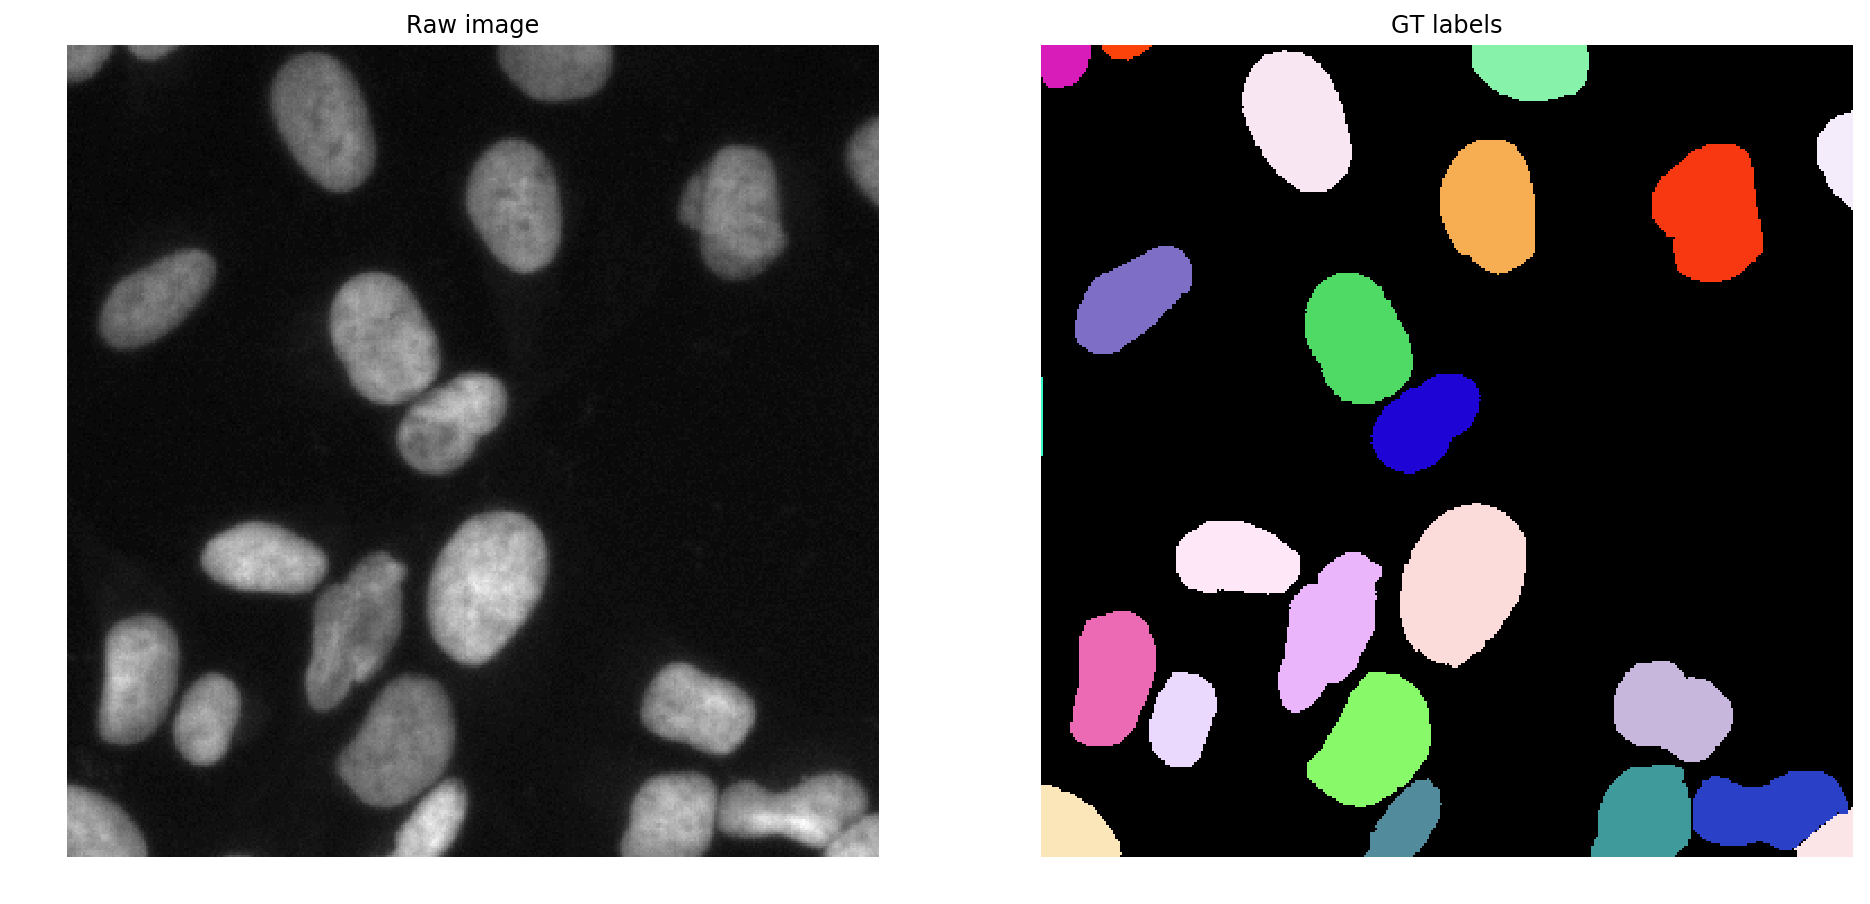

In [7]:
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

# Star-convex polygon distances (with 8 vertices)

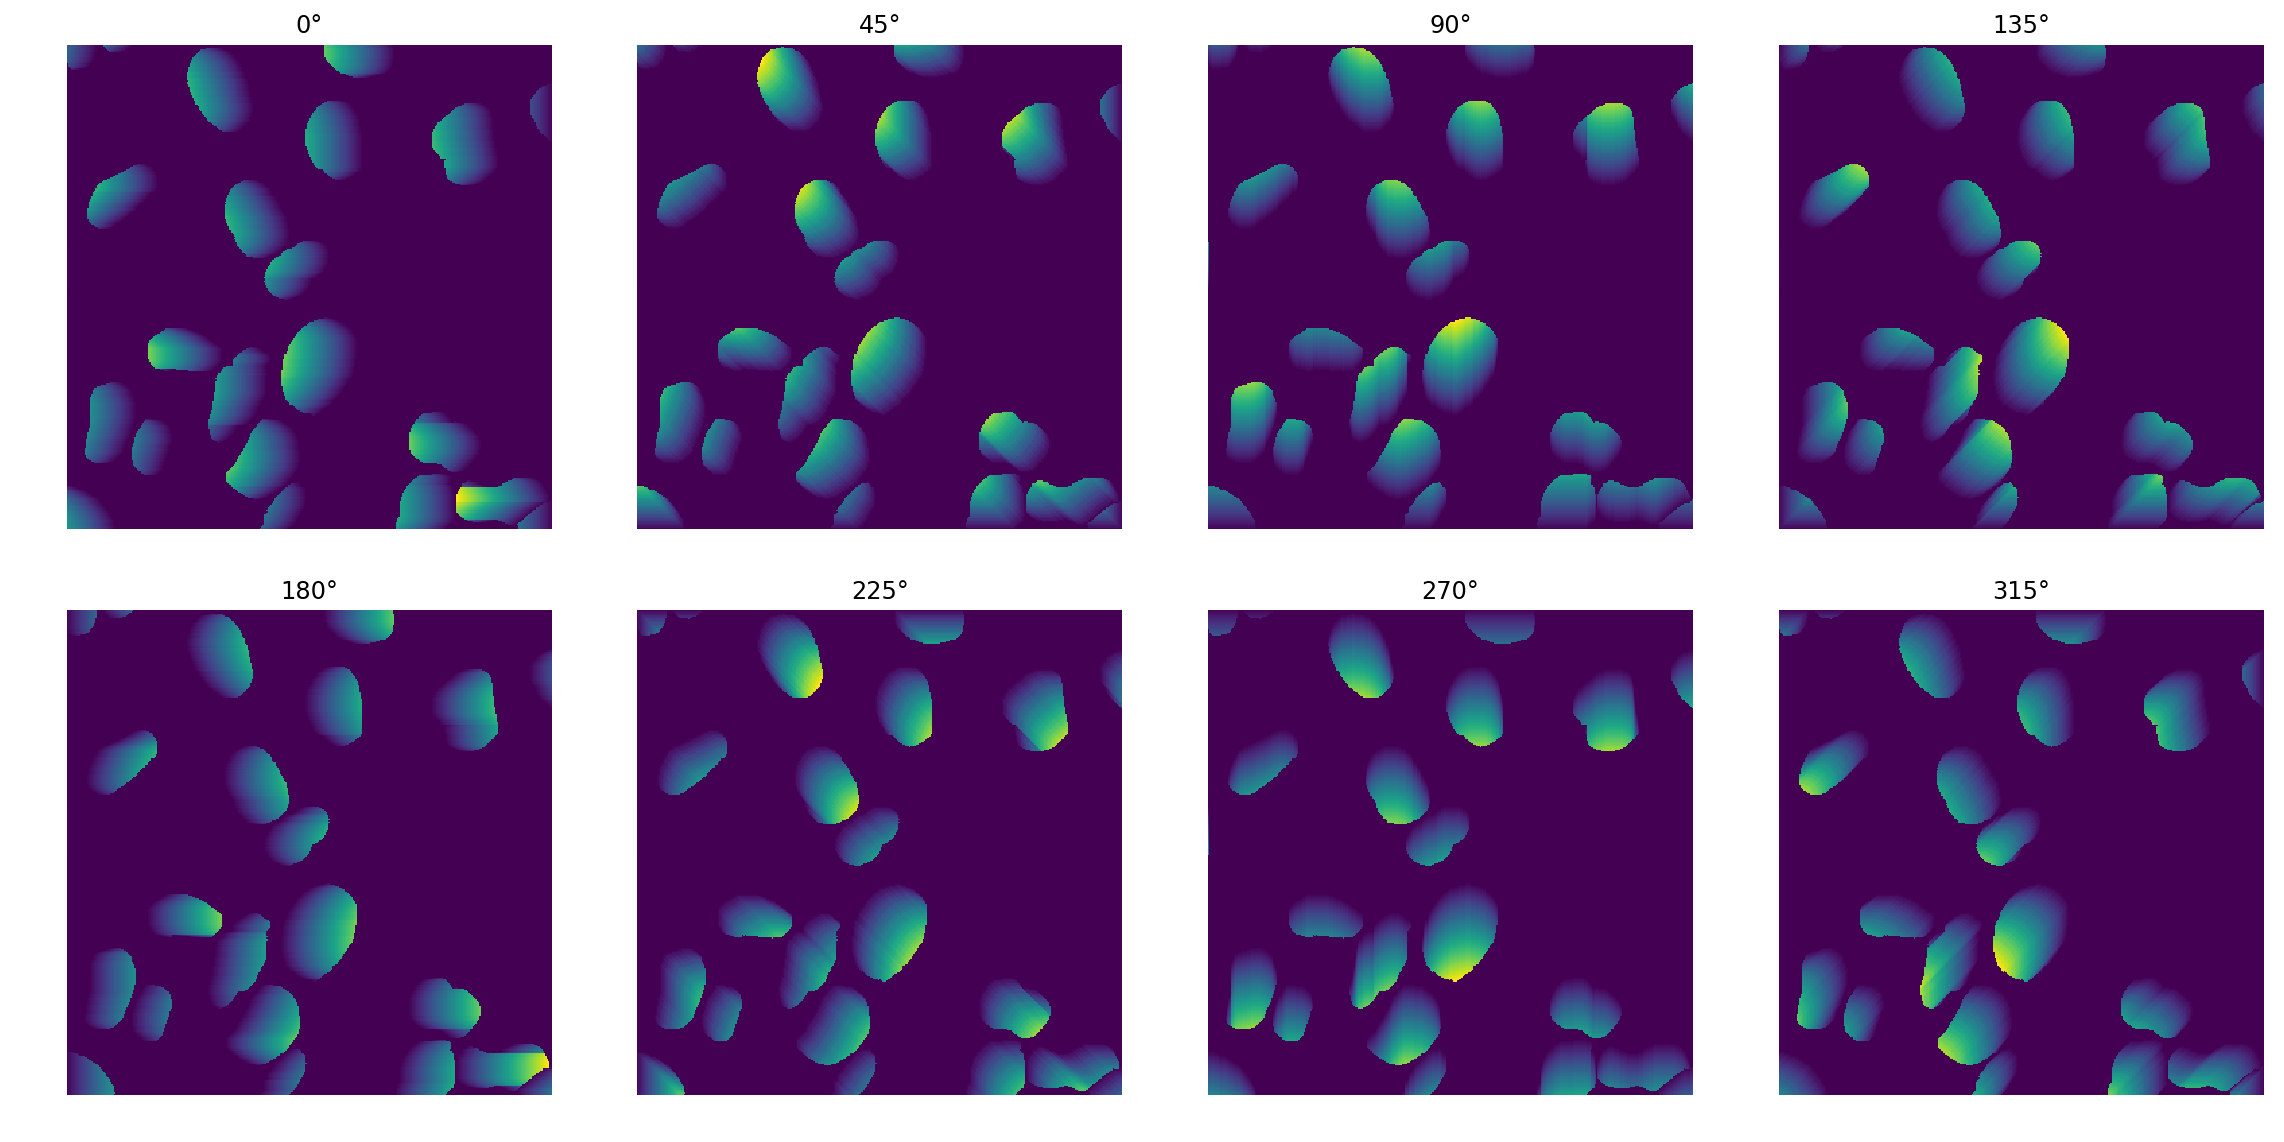

In [8]:
n_rays = 8
angl = ray_angles(n_rays)
dist = star_dist(lbl,n_rays)
fig, ax = plt.subplots(2,4, figsize=(16,8))
for a,d,g in zip(ax.flat,np.moveaxis(dist,-1,0),angl):
    a.imshow(d,cmap='viridis')
    a.set_title('%g°'%np.rad2deg(g))
    a.axis('off')
plt.tight_layout()
None;

# Object "probabilities" (Euclidean distance transform)

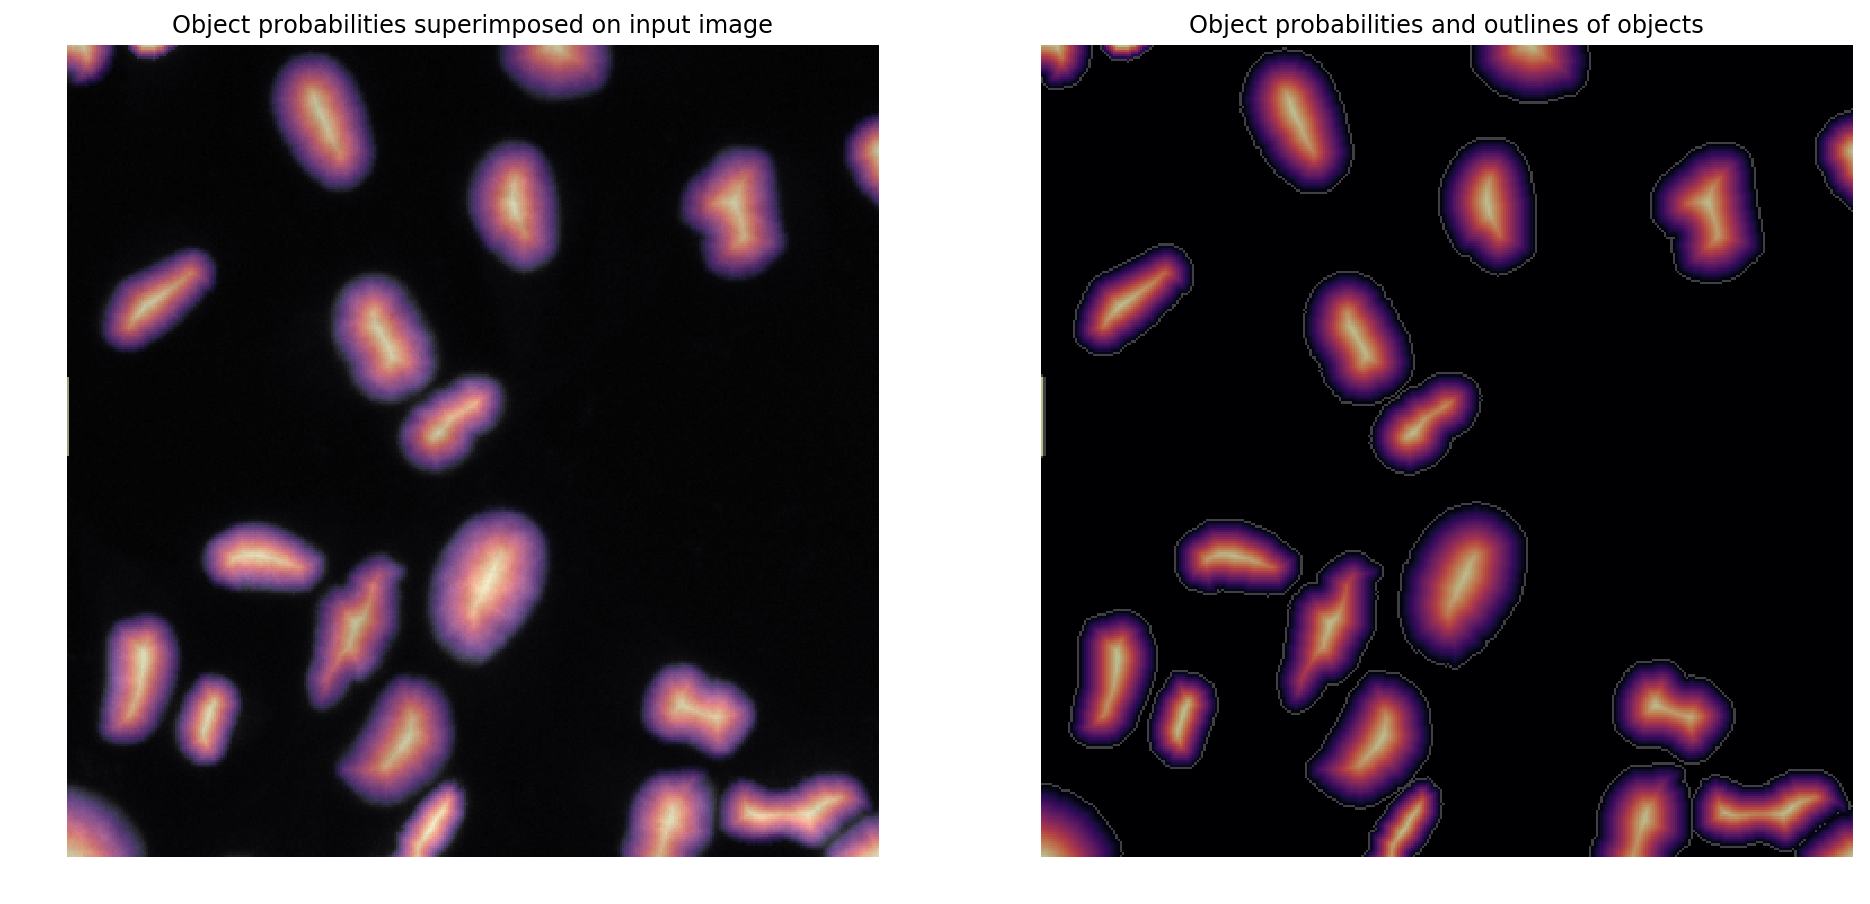

In [9]:
prob = edt_prob(lbl)
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.imshow(img,cmap='gray')
plt.imshow(prob,cmap='magma',alpha=0.6)
plt.title('Object probabilities superimposed on input image')
plt.axis('off')
plt.subplot(122)
plt.imshow(find_boundaries(lbl!=0,mode='outer'),cmap='gray')
plt.imshow(prob,cmap='magma',alpha=0.75)
plt.title('Object probabilities and outlines of objects')
plt.axis('off')
None;

# Fitting GT labels with star-convex polygons

StarDist representation with selected `n_rays`.

In [10]:
n_rays = 32
prob = edt_prob(lbl)
dist = star_dist(lbl, n_rays)

Convert star-convex distances to coordinates:

In [11]:
points, prob, dist = non_maximum_suppression(dist, prob, prob_thresh=0.5)

In [12]:
coord = dist_to_coord(dist, points)

Convert polygons to label image:

In [13]:
labels = polygons_to_label(dist, points, lbl.shape)

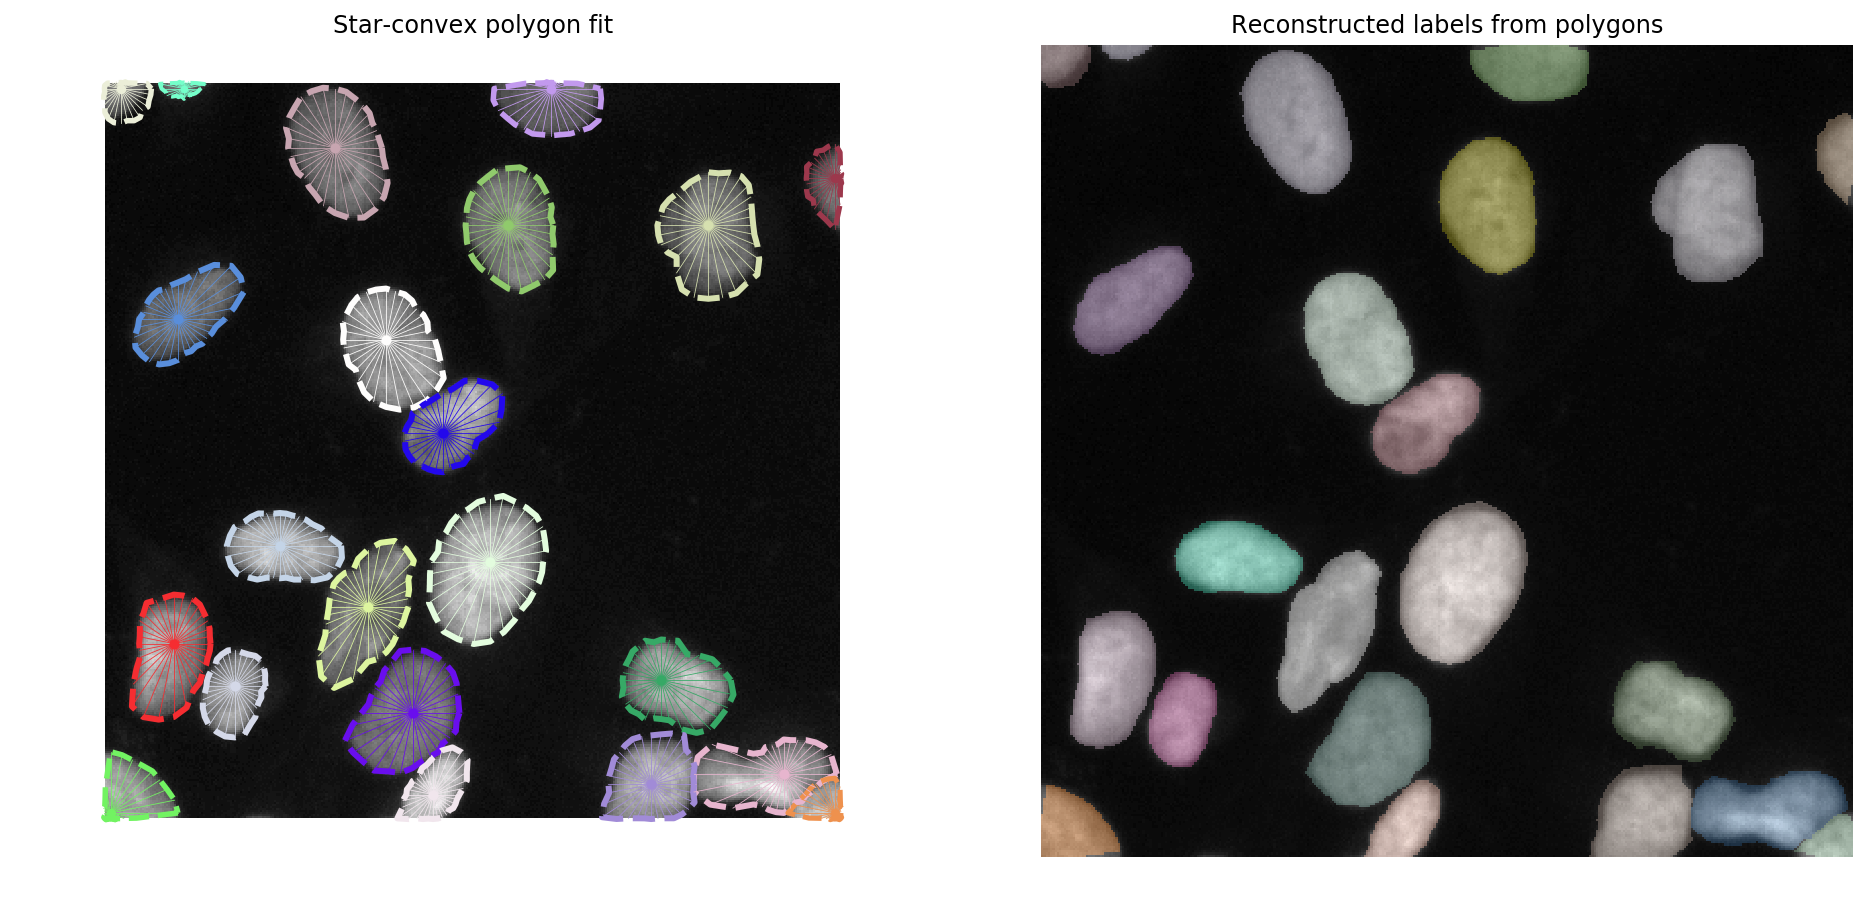

In [14]:
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.imshow(img,cmap='gray')
draw_polygons(coord,points,scores=prob, show_dist=True)
plt.axis('off')
plt.title('Star-convex polygon fit')
plt.subplot(122)
plt.imshow(img,cmap='gray')
plt.imshow(labels,cmap=lbl_cmap,alpha=0.3)
plt.axis('off')
plt.title('Reconstructed labels from polygons')
None;

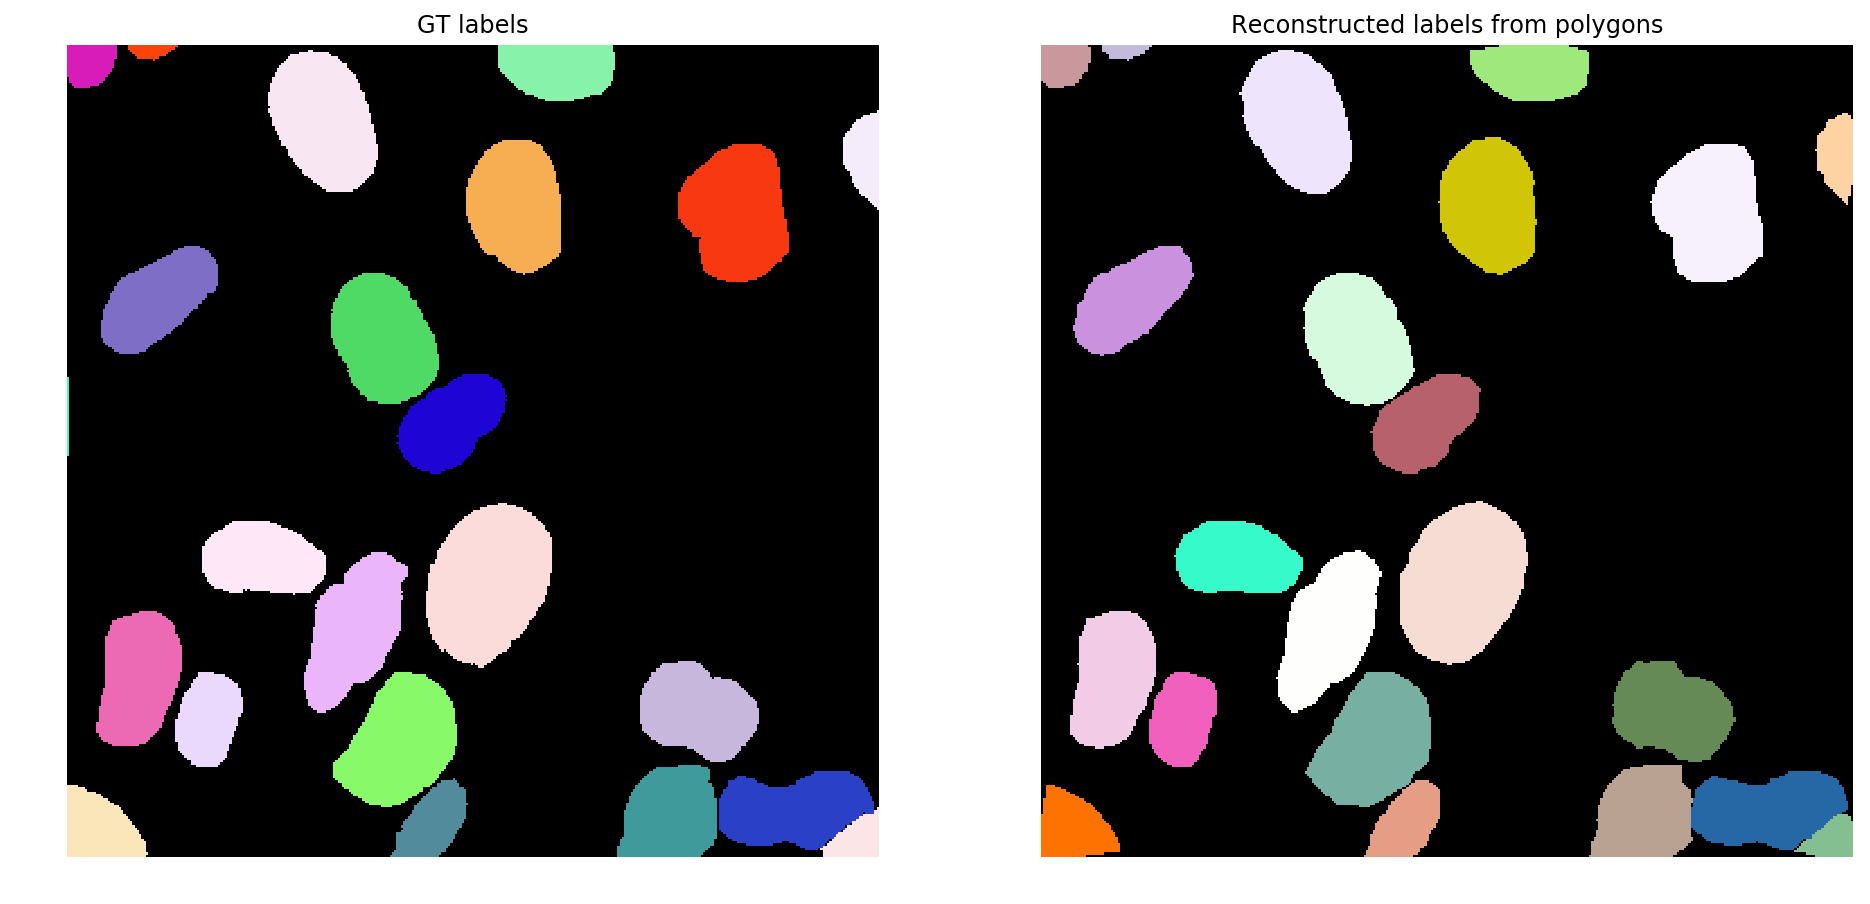

In [15]:
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(lbl,   cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
plt.subplot(122); plt.imshow(labels,cmap=lbl_cmap); plt.axis('off'); plt.title('Reconstructed labels from polygons')
None;